In [1]:
import pandas as pd
import numpy as np
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
pd.reset_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 500)


warnings.filterwarnings(action='ignore')

In [2]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import StopWordsRemover # PySpark currently does not directly support automatic stop word lists for languages other than English
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pyspark.sql.functions as F

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

In [10]:
df = spark.read.parquet('gs://msca-bdp-data-open/final_project_git/commits')

In [11]:
df = df.select("subject").sample(withReplacement=False, fraction=0.001, seed=42)

In [12]:
df.limit(20)

subject
gh-52 No need to ...
Expunge a footlin...
fix-a-typo
Update README.md
fix from Roman Ko...
encapsulate prokk...
Updated Dutch tra...
Update data.json
Avoids a PyCharm ...
Don't repeat name...


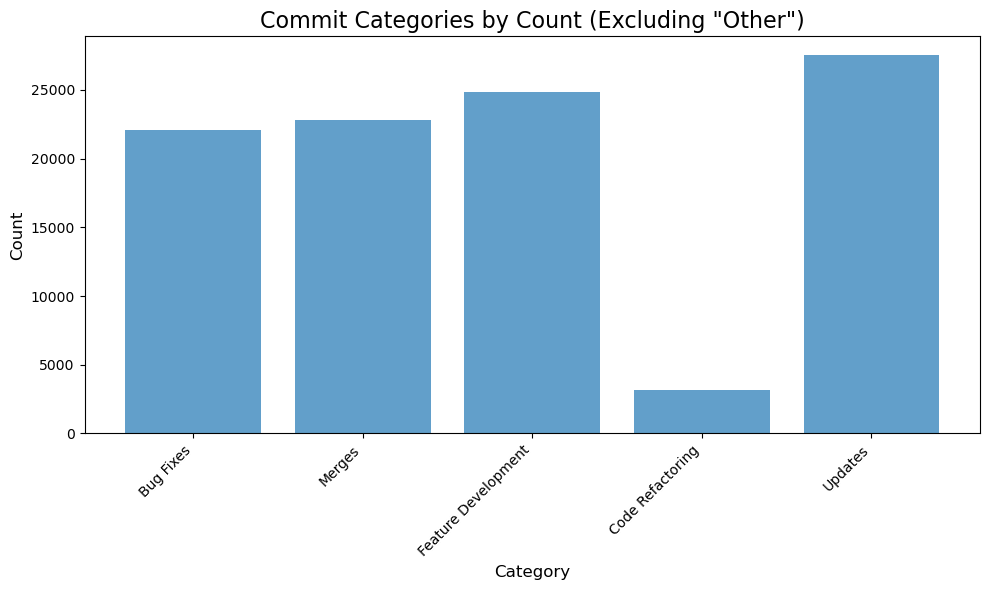

In [15]:
df = df.withColumn(
    "category",
    when(col("subject").rlike(r"(?i)\bfix\b|\bpatch\b"), "Bug Fixes")
    .when(col("subject").rlike(r"(?i)\badd\b|\bimplement\b|\bcreate\b"), "Feature Development")
    .when(col("subject").rlike(r"(?i)\brefactor\b|\boptimize\b|\bcleanup\b"), "Code Refactoring")
    .when(col("subject").rlike(r"(?i)\bupdate\b|\bmodify\b|\bchange\b"), "Updates")
    .when(col("subject").rlike(r"(?i)\bmerge\b"), "Merges")
    .otherwise("Other")
)

# Count occurrences of each category
category_counts = df.groupBy("category").agg(count("*").alias("count"))

# Convert Spark DataFrame to Pandas DataFrame
category_counts_pd = category_counts.toPandas()

filtered_df = category_counts_pd[category_counts_pd['category'] != "Other"]

# Visualize the filtered results using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['category'], filtered_df['count'], alpha=0.7)
plt.title('Commit Categories by Count (Excluding "Other")', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

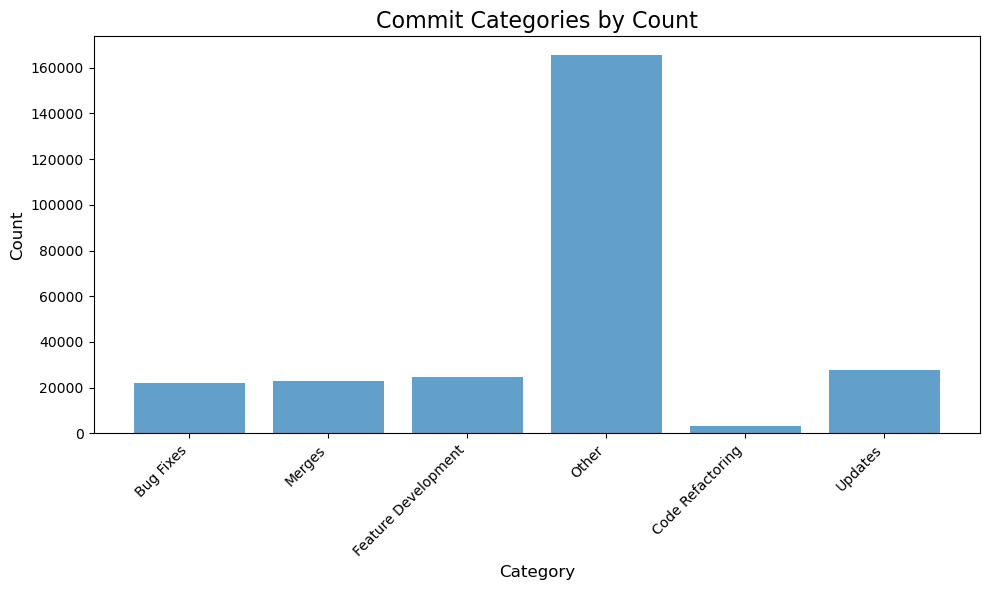

In [17]:
# Visualize the filtered results using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts_pd['category'],category_counts_pd['count'], alpha=0.7)
plt.title('Commit Categories by Count', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()